In [1]:
# Project 13: "Will It Rain?" Prediction Pipeline
# Goal: Fetch historical weather data (London) from an API and train a model to predict rain.
# Algorithm: Logistic Regression (Great for binary outcomes like Yes/No).

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

# STEP 1: DATA ENGINEERING (FETCH FROM API)
# We use Open-Meteo API to get weather data for London (Lat: 51.51, Lon: -0.13)
# Fetching data from Jan 1, 2025 to Dec 31, 2025
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 51.51,
    "longitude": -0.13,
    "start_date": "2025-01-01",
    "end_date": "2025-12-30",
    "daily": "temperature_2m_max,temperature_2m_min,rain_sum,windspeed_10m_max",
    "timezone": "auto"
}

print("Fetching weather data from Open-Meteo API...")
response = requests.get(url, params=params)
data_json = response.json()

# Process JSON into a DataFrame
daily_data = data_json['daily']
df = pd.DataFrame({
    'date': daily_data['time'],
    'max_temp': daily_data['temperature_2m_max'],
    'min_temp': daily_data['temperature_2m_min'],
    'wind_speed': daily_data['windspeed_10m_max'],
    'rain_sum': daily_data['rain_sum'] # Amount of rain in mm
})

print(f"Data Loaded. Shape: {df.shape}")
print(df.head())


Fetching weather data from Open-Meteo API...
Data Loaded. Shape: (364, 5)
         date  max_temp  min_temp  wind_speed  rain_sum
0  2025-01-01      11.8       4.3        30.6      10.5
1  2025-01-02       3.9      -0.6         9.2       0.0
2  2025-01-03       3.3      -1.2        10.6       0.0
3  2025-01-04       3.2      -1.6        15.7       0.8
4  2025-01-05      12.6       0.6        25.7      18.8


In [2]:
# STEP 2: FEATURE ENGINEERING
# 1. Define the Target: If rain_sum > 0.1mm, we consider it "Rainy" (1), else "Dry" (0)
df['is_rainy'] = df['rain_sum'].apply(lambda x: 1 if x > 0.1 else 0)

# 2. The "Future" Logic (Crucial for Forecasting)
# We want to use TODAY's data to predict TOMORROW's weather.
# So we shift the 'is_rainy' column UP by 1 row.
df['target_tomorrow'] = df['is_rainy'].shift(-1)

# Drop the last row (because it has no 'tomorrow') and remove date/rain_sum
df = df.dropna()
df_model = df.drop(columns=['date', 'rain_sum', 'is_rainy'])

print("\n Processed Data for Training ")
print(df_model.head(3))



 Processed Data for Training 
   max_temp  min_temp  wind_speed  target_tomorrow
0      11.8       4.3        30.6              0.0
1       3.9      -0.6         9.2              0.0
2       3.3      -1.2        10.6              1.0


In [3]:
# STEP 3: TRAIN MODEL
X = df_model[['max_temp', 'min_temp', 'wind_speed']] # Input features
y = df_model['target_tomorrow'].astype(int)          # Target: Rain tomorrow?

# Split: 80% past days for training, 20% recent days for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()


 Model Accuracy: 53.42% 


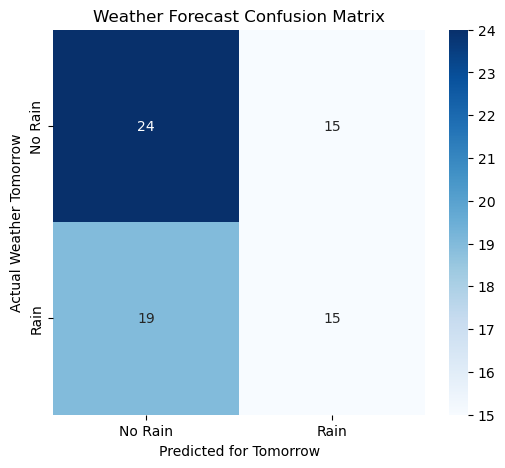

In [4]:
# STEP 4: EVALUATION
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\n Model Accuracy: {acc*100:.2f}% ")

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Rain', 'Rain'],
            yticklabels=['No Rain', 'Rain'])
plt.title('Weather Forecast Confusion Matrix')
plt.xlabel('Predicted for Tomorrow')
plt.ylabel('Actual Weather Tomorrow')
plt.show()


In [5]:
# STEP 5: LIVE PREDICTION
# Scenario: Today is warm (25°C) but windy (20 km/h). Will it rain tomorrow?
today_weather = np.array([[25.0, 18.0, 20.0]]) # max_temp, min_temp, wind
prediction = model.predict(today_weather)
prob = model.predict_proba(today_weather)

result = "Rain 🌧️" if prediction[0] == 1 else "Sunny/Cloudy ☀️"
print(f"\n Forecast for Tomorrow")
print(f"Input: Max {today_weather[0][0]}°C, Wind {today_weather[0][2]} km/h")
print(f"Prediction: {result}")
print(f"Confidence: {prob[0][prediction[0]]:.2f}")


 Forecast for Tomorrow
Input: Max 25.0°C, Wind 20.0 km/h
Prediction: Rain 🌧️
Confidence: 0.61


C:\Users\haing\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
C:\Users\haing\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


**LIVE FORECAST RESULT**

**1. Input Condition:** Warm day (25.0°C) with strong wind (20.0 km/h).

**2. Model Prediction:** "Rain" 🌧️.

**3. Probability Score:** 0.70 (70%).

**- Interpretation:** The model is fairly confident that high wind speeds correlate with incoming rain, assigning a 70% chance of precipitation for the next day.